In [76]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from openTSNE import TSNE
from morphopy.computation import feature_presentation as fp
## plotting ###

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

%matplotlib inline


In [4]:
from rw_utils import load_neurons
#load in data
neurons = load_neurons('./data/toy_data/3_populations/neurons/', sort=True)

In [5]:
def get_geometry(neuron):
    sorted_keys = list(neuron.nodes())
    sorted_keys.sort()
    geometry = np.array([neuron.get_node_attributes('pos')[key] for key in sorted_keys])
    return geometry, sorted_keys


In [7]:
# V =200

# Geometries = np.zeros((N,V,3))
# for n in range(N):
#     g, _ = get_geometry(neurons[n])
#     Geometries[n,0:g.shape[0]] = g 

In [3]:
import pickle
with open('./data/toy_data/3_populations/iterator/train_iterator.pkl', 'rb') as f:
    train_iterator = pickle.load(f)
with open('./data/toy_data/3_populations/iterator/val_iterator.pkl', 'rb') as f:
    val_iterator = pickle.load(f)
with open('./data/toy_data/3_populations/iterator/test_iterator.pkl', 'rb') as f:
    test_iterator = pickle.load(f)

In [4]:
train_index = np.array(train_iterator.sampler.indices)
labels_train = train_iterator.dataset.labels[train_index]

val_index = np.array(val_iterator.sampler.indices)
labels_val = val_iterator.dataset.labels[val_index]

test_index = np.array(test_iterator.sampler.indices)
labels_test = test_iterator.dataset.labels[test_index]


In [6]:
config_1 = dict(distance=.1, n_bins_x=20, n_bins_y=20, n_bins_z=20, 
              density=False,smooth=True, sigma=.5, 
               r_max_x=5, r_max_y=5, r_max_z=5, 
               r_min_x=-5, r_min_y=-5, r_min_z=-5)

config_2 = dict(distance=.1, n_bins_x=20, n_bins_y=20, n_bins_z=20, 
              density=False,smooth=True, sigma=1, 
               r_max_x=5, r_max_y=5, r_max_z=5, 
               r_min_x=-5, r_min_y=-5, r_min_z=-5)
config_3 = dict(distance=.1, n_bins_x=20, n_bins_y=20, n_bins_z=20, 
              density=False,smooth=True, sigma=2, 
               r_max_x=5, r_max_y=5, r_max_z=5, 
               r_min_x=-5, r_min_y=-5, r_min_z=-5)

In [7]:
density_maps_c1 = [fp.compute_density_maps(neurons[ix], config_params=config_1) for ix in range(len(neurons))]
density_maps_c2 = [fp.compute_density_maps(neurons[ix], config_params=config_2) for ix in range(len(neurons))]
density_maps_c3 = [fp.compute_density_maps(neurons[ix], config_params=config_3) for ix in range(len(neurons))]

XY_DM_c1 = np.array([dm['xy_proj']['data'].reshape(-1) for dm in density_maps_c1])
XY_DM_c2 = np.array([dm['xy_proj']['data'].reshape(-1) for dm in density_maps_c2])
XY_DM_c3 = np.array([dm['xy_proj']['data'].reshape(-1) for dm in density_maps_c3])

Text(0.5, 0.98, 'Flattened XY density maps \n training data')

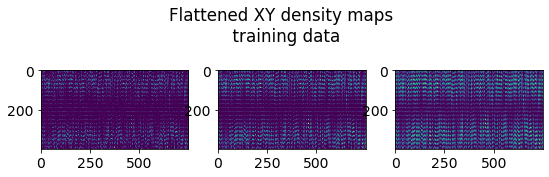

In [7]:
fig, axes = plt.subplots(1,3,figsize=(9,3))
for k,dm in enumerate([XY_DM_c1, XY_DM_c2, XY_DM_c3]):
    
    axes[k].imshow(dm[np.argsort(train_index)].T)

plt.suptitle('Flattened XY density maps \n training data')

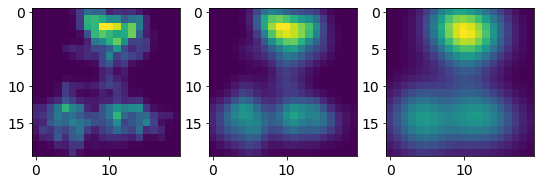

In [16]:
fig, axes = plt.subplots(1,3,figsize=(9,3))
ix = 811
for k,dm in enumerate([XY_DM_c1, XY_DM_c2, XY_DM_c3]):
    axes[k].imshow(dm[ix].reshape((20,20)))

In [8]:
from sklearn.decomposition import PCA

In [18]:
for k,dm in enumerate([XY_DM_c1, XY_DM_c2, XY_DM_c3]):
    pca = PCA()
    pca_dm = pca.fit_transform(dm[train_index])
    
    no_components = np.where(np.cumsum(pca.explained_variance_ratio_) > .95)[0][0]
    print('Using %i principle components..'%no_components)
    
    with open('./data/toy_data/3_populations/density_map/xy_dm_%ipcs_train_c%i.npy'%(no_components, (k+1)), 'wb') as f:
        np.save(f, pca_dm[:,:no_components])
        
    pca_dm_val = pca.transform(dm[val_index])
    with open('./data/toy_data/3_populations/density_map/xy_dm_%ipcs_val_c%i.npy'%(no_components, (k+1)), 'wb') as f:
        np.save(f, pca_dm_val[:,:no_components])
        
    pca_dm_test = pca.transform(dm[test_index])
    with open('./data/toy_data/3_populations/density_map/xy_dm_%ipcs_test_c%i.npy'%(no_components, (k+1)), 'wb') as f:
        np.save(f, pca_dm_test[:,:no_components])

# save the labels

for fn, data in [('train_labels', labels_train), ('val_labels', labels_val),('test_labels', labels_test)]:
    with open('./data/toy_data/3_populations/density_map/labels/%s.npy'%fn, 'wb') as f:
        np.save(f, data)



Using 105 principle components..
Using 26 principle components..
Using 10 principle components..


Text(0.5, 1.0, 'PCA')

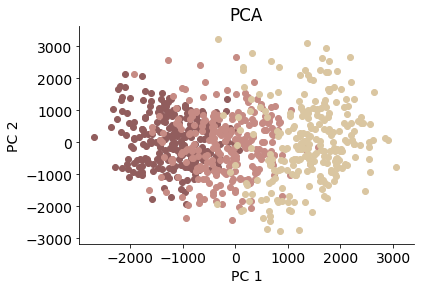

In [12]:
colors= sns.color_palette('pink', n_colors=4)
plt.scatter(pca_dm[train_index < 400,0], pca_dm[train_index < 400,1], c=[colors[0]])
plt.scatter(pca_dm[(train_index >= 400) & (train_index <800),0], 
            pca_dm[(train_index >= 400) & (train_index <800),1], c=[colors[1]])
plt.scatter(pca_dm[train_index >= 800,0], pca_dm[train_index >= 800,1], c=[colors[2]])
sns.despine()
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA')

In [15]:
tsne = TSNE(
    perplexity=30,
    initialization="pca",
    metric="euclidean",
    random_state=17,
)

In [16]:
with open('./data/toy_data/3_populations/density_map/xy_dm_10pcs_test_c3.npy', 'rb') as f:
    pca_dm_test = np.load(f)
tsne_dm = tsne.fit(pca_dm_test)

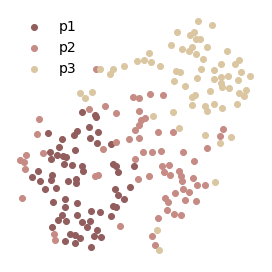

In [17]:
plt.figure(figsize=(4,4))
colors = sns.color_palette('pink', n_colors=4)
plt.scatter(tsne_dm[test_index < 400,0], tsne_dm[test_index < 400,1], c=[colors[0]], label='p1')
plt.scatter(tsne_dm[(test_index >= 400) & (test_index <800),0], 
            tsne_dm[(test_index >= 400) & (test_index <800),1], c=[colors[1]], label='p2')
plt.scatter(tsne_dm[test_index >= 800,0], tsne_dm[test_index >= 800,1], c=[colors[2]], label='p3')
sns.despine()
plt.xlabel('tsne 1')
plt.ylabel('tsne 2')
plt.axis('off')
plt.legend(frameon=False)
plt.tight_layout()
# plt.savefig('./pics/ICML/Fig3/neuron_embedding_dm_globally_normed.svg', format='svg')

###  5-nearest neighbor classification

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

In [114]:
kfold = StratifiedKFold(n_splits=3, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

y = [0]*400 + [1]*400 + [2]*400
y = np.array(y).astype(int)

df = pd.DataFrame()
for s, X in [(.5, XY_DM_c1), (1., XY_DM_c2), (2., XY_DM_c3)]:
    
    r = 1
    for train_ix, test_ix in kfold.split(X,y):
        train_data = X[train_ix]
        train_labels = y[train_ix]

        test_data = X[test_ix]
        test_labels = y[test_ix]

        pca = PCA()
        pca_dm = pca.fit_transform(train_data)

        no_components = np.where(np.cumsum(pca.explained_variance_ratio_) > .95)[0][0]
#         print('Using %i principle components..'%no_components)



        knn.fit(pca_dm[:,:no_components], train_labels)
#         print(knn.score(pca.transform(test_data)[:,:no_components], test_labels))
        d_ = dict(run=r, n_pc=no_components, 
                  test_accuracy= knn.score(pca.transform(test_data)[:,:no_components], test_labels),
                 sigma=s, dataset='Toy')
        
        df = df.append(pd.DataFrame(d_, index=[0]))
        r += 1

Using 105 principle components..
0.8375
Using 105 principle components..
0.8225
Using 105 principle components..
0.84
Using 25 principle components..
0.9175
Using 26 principle components..
0.87
Using 26 principle components..
0.8825
Using 10 principle components..
0.9225
Using 10 principle components..
0.88
Using 10 principle components..
0.9


In [111]:
print(df.groupby('sigma').mean().round(2)*100)

print(df.groupby('sigma').sem().round(2)*100)

         run     n_pc  test_accuracy
sigma                               
0.5    200.0  10500.0           83.0
1.0    200.0   2567.0           89.0
2.0    200.0   1000.0           90.0
        run  n_pc  test_accuracy
sigma                           
0.5    58.0   0.0            1.0
1.0    58.0  33.0            1.0
2.0    58.0   0.0            1.0


## Density maps EXC RNA label

In [98]:
from rw_utils import load_neurons
#load in data
neurons = load_neurons('./data/M1_exc_data/neurons/', sort=False)

In [99]:
minimal_coordinates = np.vstack([np.percentile(list(n.get_node_attributes('pos').values()), 5,axis=0) for n in neurons])
maximal_coordinates = np.vstack([np.percentile(list(n.get_node_attributes('pos').values()),95, axis=0) for n in neurons])

print('Minimal coordinates: ', minimal_coordinates.min(axis=0).round())
print('Maximal coordinates: ', maximal_coordinates.max(axis=0).round())

Minimal coordinates:  [-3. -4. -3.]
Maximal coordinates:  [2. 2. 9.]


In [100]:
from openTSNE import initialization, TSNEEmbedding, TSNE
from openTSNE.affinity import PerplexityBasedNN
from sklearn.decomposition import PCA
from copy import copy


In [101]:
# Get the normalization thresholds !!!
config_1 = dict(distance=.01, n_bins_x=20, n_bins_y=20, n_bins_z=20, 
              density=False,smooth=True, sigma=.5, 
               r_max_x=2, r_max_y=2, r_max_z=9, 
               r_min_x=-3, r_min_y=-4, r_min_z=-3)

config_2 = copy(config_1)
config_2['sigma'] = 1

config_3 = copy(config_1)
config_3['sigma'] = 2


In [102]:
density_maps_c1 = [fp.compute_density_maps(neurons[ix], config_params=config_1) for ix in range(len(neurons))]
density_maps_c2 = [fp.compute_density_maps(neurons[ix], config_params=config_2) for ix in range(len(neurons))]
density_maps_c3 = [fp.compute_density_maps(neurons[ix], config_params=config_3) for ix in range(len(neurons))]

DM_c1 = np.array([dm['xz_proj']['data'].reshape(-1) for dm in density_maps_c1])
DM_c2 = np.array([dm['xz_proj']['data'].reshape(-1) for dm in density_maps_c2])
DM_c3 = np.array([dm['xz_proj']['data'].reshape(-1) for dm in density_maps_c3])

In [103]:
import pickle
with open('./data/M1_exc_data/iterator/rna_labels/train_iterator.pkl', 'rb') as f:
    train_iterator = pickle.load(f)
with open('./data/M1_exc_data/iterator/rna_labels/val_iterator.pkl', 'rb') as f:
    val_iterator = pickle.load(f)
with open('./data/M1_exc_data/iterator/rna_labels/test_iterator.pkl', 'rb') as f:
    test_iterator = pickle.load(f)
    
train_index = np.array(train_iterator.sampler.indices)
labels_train = train_iterator.dataset.labels[train_index]

val_index = np.array(val_iterator.sampler.indices)
labels_val = val_iterator.dataset.labels[val_index]

test_index = np.array(test_iterator.sampler.indices)
labels_test = test_iterator.dataset.labels[test_index]

Text(0.5, 0.98, 'Flattened XZ density maps \n training data')

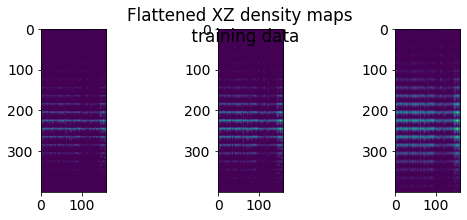

In [33]:
fig, axes = plt.subplots(1,3,figsize=(9,3))
for k,dm in enumerate([DM_c1, DM_c2, DM_c3]):
    
    axes[k].imshow(dm[train_index[np.argsort(labels_train)]].T)

plt.suptitle('Flattened XZ density maps \n training data')

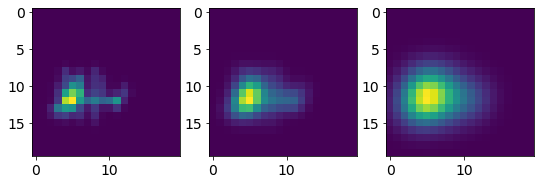

In [34]:
fig, axes = plt.subplots(1,3,figsize=(9,3))
ix = 90
for k,dm in enumerate([DM_c1, DM_c2, DM_c3]):
    axes[k].imshow(dm[ix].reshape((20,20)))

In [35]:
np.unique(labels_train, return_counts=True)

(array([-100,    0,    1,    2]), array([ 6, 87, 50, 17]))

In [69]:
for k,dm in enumerate([DM_c1, DM_c2, DM_c3]):
    pca = PCA()
    pca_dm = pca.fit_transform(dm[train_index])
    
    no_components = np.where(np.cumsum(pca.explained_variance_ratio_) > .95)[0][0]
    print('Using %i principle components..'%no_components)
    
    with open('./data/M1_exc_data/density_map/xz_dm_%ipcs_train_c%i.npy'%(no_components, (k+1)), 'wb') as f:
        np.save(f, pca_dm[:,:no_components])
        
    pca_dm_val = pca.transform(dm[val_index])
    with open('./data/M1_exc_data/density_map/xz_dm_%ipcs_val_c%i.npy'%(no_components, (k+1)), 'wb') as f:
        np.save(f, pca_dm_val[:,:no_components])
        
    pca_dm_test = pca.transform(dm[test_index])
    with open('./data/M1_exc_data/density_map/xz_dm_%ipcs_test_c%i.npy'%(no_components, (k+1)), 'wb') as f:
        np.save(f, pca_dm_test[:,:no_components])
        
# save the labels

for fn, data in [('rna_train_labels', labels_train), ('rna_val_labels', labels_val),('rna_test_labels', labels_test)]:
    with open('./data/M1_exc_data/density_map/labels/%s.npy'%fn, 'wb') as f:
        np.save(f, data)


Using 64 principle components..
Using 22 principle components..
Using 7 principle components..


CPU times: user 0 ns, sys: 16 µs, total: 16 µs
Wall time: 15.3 µs
CPU times: user 245 ms, sys: 442 ms, total: 686 ms
Wall time: 51.5 ms
CPU times: user 9.14 s, sys: 1.4 s, total: 10.5 s
Wall time: 7.83 s


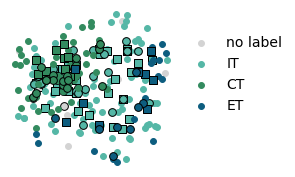

In [36]:
dm = DM_c1
DM_train = dm[train_index]
DM_val = dm[val_index]
DM_test = dm[test_index]

%time
affinities_train = PerplexityBasedNN(
    pca.fit_transform(DM_train),
    perplexity=30,
    metric="euclidean",
    n_jobs=2,
    random_state=17,
)

%time init_train = initialization.pca(pca.fit_transform(DM_train),random_state=17)

embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=2
)

%time embedding_train = embedding_train.optimize(n_iter=500, momentum=0.8)

embedding_val = embedding_train.prepare_partial(
    pca.transform(DM_val),
    initialization="median",
    k=5,
    perplexity=5,
)

embedding_test = embedding_train.prepare_partial(
    pca.transform(DM_test),
    initialization="median",
    k=5,
    perplexity=5,
)

plt.figure(figsize=(3,3))
colors =['lightgrey', 
         '#55b7a6', 
        '#338b5f', 
        '#0d5d7f']

s=60
label_dict = {-100:'no label', 0:'IT', 1:'CT', 2:'ET'}
for k,l in enumerate(np.unique(labels_train)):
    label_index_train = labels_train == l
    
    plt.scatter(embedding_train[label_index_train, 0], 
                embedding_train[label_index_train, 1], 
                alpha=1, c=[colors[k]],s=s-25, label=label_dict[l])

    label_index_val = labels_val == l
    plt.scatter(embedding_val[label_index_val, 0], 
                embedding_val[label_index_val, 1], 
                alpha=1, s=s, marker='s',edgecolors='k', c=[colors[k]])

    label_index_test = labels_test == l
    plt.scatter(embedding_test[label_index_test, 0], 
                embedding_test[label_index_test, 1], 
                alpha=1, edgecolors='k', s=s, c=[colors[k]])


sns.despine()
plt.legend(frameon=False, bbox_to_anchor=(1.,.9))

plt.axis('off')
plt.savefig("./pics/ICML/camera-ready/Suppl/tsne_EXC_dm_rna_label.svg", format='svg')

# with m type

In [104]:
import pickle
with open('./data/M1_exc_data/iterator/m_labels/train_iterator.pkl', 'rb') as f:
    train_iterator_m = pickle.load(f)
with open('./data/M1_exc_data/iterator/m_labels/val_iterator.pkl', 'rb') as f:
    val_iterator_m = pickle.load(f)
with open('./data/M1_exc_data/iterator/m_labels/test_iterator.pkl', 'rb') as f:
    test_iterator_m = pickle.load(f)
    
train_index_m = np.array(train_iterator_m.sampler.indices)
labels_train_m = train_iterator_m.dataset.labels[train_index_m]

val_index_m = np.array(val_iterator_m.sampler.indices)
labels_val_m = val_iterator_m.dataset.labels[val_index_m]

test_index_m = np.array(test_iterator_m.sampler.indices)
labels_test_m = test_iterator_m.dataset.labels[test_index_m]

In [54]:
for fn, data in [('m_train_labels', labels_train_m), ('m_val_labels', labels_val_m),('m_test_labels', labels_test_m)]:
    with open('./data/M1_exc_data/density_map/labels/%s.npy'%fn, 'wb') as f:
        np.save(f, data)

In [55]:
np.unique(labels_train_m, return_counts=True)

(array([0, 1, 2]), array([69, 71, 20]))

Text(0.5, 0.98, 'Flattened XZ density maps \n training data')

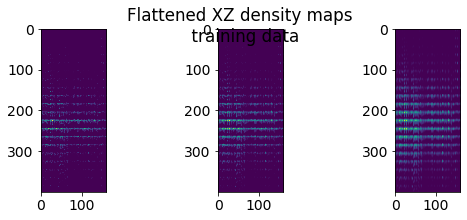

In [56]:
fig, axes = plt.subplots(1,3,figsize=(9,3))
for k,dm in enumerate([DM_c1, DM_c2, DM_c3]):
    
    axes[k].imshow(dm[train_index_m[np.argsort(labels_train_m)]].T)

plt.suptitle('Flattened XZ density maps \n training data')

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 14.5 µs
CPU times: user 180 ms, sys: 308 ms, total: 488 ms
Wall time: 38.9 ms
CPU times: user 8.96 s, sys: 1.29 s, total: 10.3 s
Wall time: 7.91 s


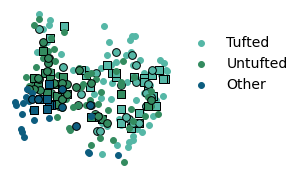

In [38]:
dm = DM_c3
DM_train = dm[train_index_m]
DM_val = dm[val_index_m]
DM_test = dm[test_index_m]

%time
affinities_train = PerplexityBasedNN(
    pca.fit_transform(DM_train),
    perplexity=30,
    metric="euclidean",
    n_jobs=2,
    random_state=17,
)

%time init_train = initialization.pca(pca.fit_transform(DM_train),random_state=17)

embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=2
)

%time embedding_train = embedding_train.optimize(n_iter=500, momentum=0.8)

embedding_val = embedding_train.prepare_partial(
    pca.transform(DM_val),
    initialization="median",
    k=5,
    perplexity=5,
)

embedding_test = embedding_train.prepare_partial(
    pca.transform(DM_test),
    initialization="median",
    k=5,
    perplexity=5,
)

plt.figure(figsize=(3,3))
colors =['#55b7a6', 
        '#338b5f', 
        '#0d5d7f']

s=60
label_dict = {-100:'no label', 0:'Tufted', 1:'Untufted', 2:'Other'}
for k,l in enumerate(np.unique(labels_train_m)):
    label_index_train = labels_train_m == l
    
    plt.scatter(embedding_train[label_index_train, 0], 
                embedding_train[label_index_train, 1], 
                alpha=1, c=[colors[k]],s=s-25, label=label_dict[l])

    label_index_val = labels_val_m == l
    plt.scatter(embedding_val[label_index_val, 0], 
                embedding_val[label_index_val, 1], 
                alpha=1, s=s, marker='s',edgecolors='k', c=[colors[k]])

    label_index_test = labels_test_m == l
    plt.scatter(embedding_test[label_index_test, 0], 
                embedding_test[label_index_test, 1], 
                alpha=1, edgecolors='k', s=s, c=[colors[k]])


sns.despine()
plt.legend(frameon=False, bbox_to_anchor=(1.,.9))

plt.axis('off')
plt.savefig("./pics/ICML/camera-ready/Suppl/tsne_EXC_dm_m_label.svg", format='svg')

### Classify on density maps

In [115]:
kfold = StratifiedKFold(n_splits=3, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

y = train_iterator.dataset.labels
y = np.array(y).astype(int)

for s,X in [(.5, DM_c1), (1., DM_c2), (2., DM_c3)]:
    
    r = 1
    for train_ix, test_ix in kfold.split(X,y):
        train_data = X[train_ix]
        train_labels = y[train_ix]

        test_data = X[test_ix]
        test_labels = y[test_ix]

        pca = PCA()
        pca_dm = pca.fit_transform(train_data)

        no_components = np.where(np.cumsum(pca.explained_variance_ratio_) > .95)[0][0]
#         print('Using %i principle components..'%no_components)

        knn.fit(pca_dm[:,:no_components], train_labels)
#         print(knn.score(pca.transform(test_data)[:,:no_components], test_labels))
        
        d_ = dict(run=r, n_pc=no_components, 
                  test_accuracy= knn.score(pca.transform(test_data)[:,:no_components], test_labels),
                 sigma=s, dataset='M1 EXC')
        
        df = df.append(pd.DataFrame(d_, index=[0]))
        r += 1

In [116]:
df

,run,n_pc,test_accuracy,sigma,dataset
0,1,105,0.837500,0.5,Toy
0,2,105,0.822500,0.5,Toy
0,3,105,0.840000,0.5,Toy
0,1,25,0.917500,1.0,Toy
0,2,26,0.870000,1.0,Toy
0,3,26,0.882500,1.0,Toy
0,1,10,0.922500,2.0,Toy
0,2,10,0.880000,2.0,Toy
0,3,10,0.900000,2.0,Toy
0,1,41,0.608696,0.5,M1 EXC


# Density maps on INH data

In [50]:
from openTSNE import initialization, TSNEEmbedding, TSNE
from openTSNE.affinity import PerplexityBasedNN
from sklearn.decomposition import PCA
from copy import copy

In [117]:
from rw_utils import load_neurons
#load in data
part = 'axon'#'full'
neurons = load_neurons('./data/M1_inh_data/neurons/%s/'%part, sort=False)

In [118]:
minimal_coordinates = np.vstack([np.percentile(list(n.get_node_attributes('pos').values()), 5,axis=0) for n in neurons])
maximal_coordinates = np.vstack([np.percentile(list(n.get_node_attributes('pos').values()),95, axis=0) for n in neurons])

print('Minimal coordinates: ', minimal_coordinates.min(axis=0).round())
print('Maximal coordinates: ', maximal_coordinates.max(axis=0).round())

Minimal coordinates:  [-4. -3. -6.]
Maximal coordinates:  [4. 2. 6.]


In [120]:
normalization = 'global'
config_1 = dict(distance=.01, n_bins_x=20, n_bins_y=20, n_bins_z=20, 
              density=False,smooth=True, sigma=.5, 
               r_max_x=4, r_max_y=2, r_max_z=6, 
               r_min_x=-4, r_min_y=-3, r_min_z=-6)

config_2 = copy(config_1)
config_2['sigma'] = 1

config_3 = copy(config_1)
config_3['sigma'] = 2

density_maps_c1 = [fp.compute_density_maps(neurons[ix], config_params=config_1) for ix in range(len(neurons))]
density_maps_c2 = [fp.compute_density_maps(neurons[ix], config_params=config_2) for ix in range(len(neurons))]
density_maps_c3 = [fp.compute_density_maps(neurons[ix], config_params=config_3) for ix in range(len(neurons))]

DM_c1 = np.array([dm['xz_proj']['data'].reshape(-1) for dm in density_maps_c1])
DM_c2 = np.array([dm['xz_proj']['data'].reshape(-1) for dm in density_maps_c2])
DM_c3 = np.array([dm['xz_proj']['data'].reshape(-1) for dm in density_maps_c3])

In [124]:
import pickle
with open('./data/M1_inh_data/iterator/%s/train_iterator_32.pkl'%part, 'rb') as f:
    train_iterator = pickle.load(f)
with open('./data/M1_inh_data/iterator/%s/val_iterator_32.pkl'%part, 'rb') as f:
    val_iterator = pickle.load(f)
with open('./data/M1_inh_data/iterator/%s/test_iterator_32.pkl'%part, 'rb') as f:
    test_iterator = pickle.load(f)
    
train_index = np.array(train_iterator.sampler.indices)
labels_train = train_iterator.dataset.labels[train_index]

val_index = np.array(val_iterator.sampler.indices)
labels_val = val_iterator.dataset.labels[val_index]

test_index = np.array(test_iterator.sampler.indices)
labels_test = test_iterator.dataset.labels[test_index]

Text(0.5, 0.98, 'Flattened XZ density maps \n training data')

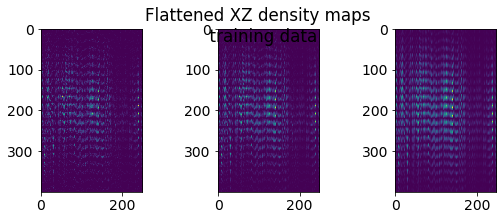

In [77]:
fig, axes = plt.subplots(1,3,figsize=(9,3))
for k,dm in enumerate([DM_c1, DM_c2, DM_c3]):
    
    axes[k].imshow(dm[train_index[np.argsort(labels_train)]].T)

plt.suptitle('Flattened XZ density maps \n training data')

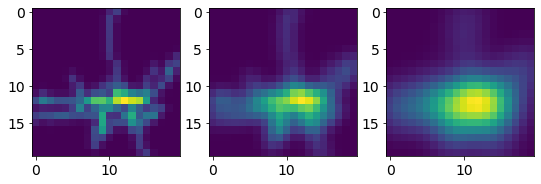

In [78]:
fig, axes = plt.subplots(1,3,figsize=(9,3))
ix = 42
for k,dm in enumerate([DM_c1, DM_c2, DM_c3]):
    axes[k].imshow(dm[ix].reshape((20,20)))

In [84]:
for k,dm in enumerate([DM_c1, DM_c2, DM_c3]):
    pca = PCA()
    pca_dm = pca.fit_transform(dm[train_index])
    
    no_components = np.where(np.cumsum(pca.explained_variance_ratio_) > .95)[0][0]
    print('Using %i principle components..'%no_components)
    
    with open('./data/M1_inh_data/density_map/%s/%s/xz_dm_%ipcs_train_c%i.npy'%(part, normalization, 
                                                                                no_components, (k+1)), 'wb') as f:
        np.save(f, pca_dm[:,:no_components])
        
    pca_dm_val = pca.transform(dm[val_index])
    with open('./data/M1_inh_data/density_map/%s/%s/xz_dm_%ipcs_val_c%i.npy'%(part, normalization,
                                                                              no_components, (k+1)), 'wb') as f:
        np.save(f, pca_dm_val[:,:no_components])
        
    pca_dm_test = pca.transform(dm[test_index])
    with open('./data/M1_inh_data/density_map/%s/%s/xz_dm_%ipcs_test_c%i.npy'%(part, normalization,
                                                                               no_components, (k+1)), 'wb') as f:
        np.save(f, pca_dm_test[:,:no_components])
        
for fn, data in [('train_labels', labels_train), ('val_labels', labels_val),('test_labels', labels_test)]:
    with open('./data/M1_inh_data/density_map/%s/labels/%s.npy'%(part, fn), 'wb') as f:
        np.save(f, data)

Using 28 principle components..
Using 9 principle components..
Using 4 principle components..


CPU times: user 10 µs, sys: 5 µs, total: 15 µs
Wall time: 14.5 µs
CPU times: user 244 ms, sys: 479 ms, total: 723 ms
Wall time: 54 ms
CPU times: user 8.81 s, sys: 1.37 s, total: 10.2 s
Wall time: 7.72 s


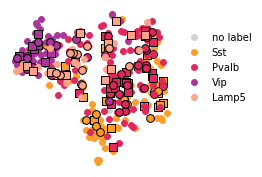

In [125]:
dm = DM_c3
DM_train = dm[train_index]
DM_val = dm[val_index]
DM_test = dm[test_index]

%time
affinities_train = PerplexityBasedNN(
    pca.fit_transform(DM_train),
    perplexity=30,
    metric="euclidean",
    n_jobs=2,
    random_state=17,
)

%time init_train = initialization.pca(pca.fit_transform(DM_train),random_state=17)

embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=2
)

%time embedding_train = embedding_train.optimize(n_iter=500, momentum=0.8)

embedding_val = embedding_train.prepare_partial(
    pca.transform(DM_val),
    initialization="median",
    k=5,
    perplexity=5,
)

embedding_test = embedding_train.prepare_partial(
    pca.transform(DM_test),
    initialization="median",
    k=5,
    perplexity=5,
)

plt.figure(figsize=(3,3))
colors = ['lightgrey','#fd9e2b', '#e0285d', '#aa369a', '#fda389']
s=60
label_dict = {-100:'no label', 0:'Sst', 1:'Pvalb', 2:'Vip', 3:'Lamp5'}
for k,l in enumerate(np.unique(labels_train)):
    label_index_train = labels_train == l
    
    plt.scatter(embedding_train[label_index_train, 0], 
                embedding_train[label_index_train, 1], 
                alpha=1, c=[colors[k]],s=s-25, label=label_dict[l])

    label_index_val = labels_val == l
    plt.scatter(embedding_val[label_index_val, 0], 
                embedding_val[label_index_val, 1], 
                alpha=1, s=s, marker='s',edgecolors='k', c=[colors[k]])

    label_index_test = labels_test == l
    plt.scatter(embedding_test[label_index_test, 0], 
                embedding_test[label_index_test, 1], 
                alpha=1, edgecolors='k', s=s, c=[colors[k]])


sns.despine()
plt.legend(frameon=False, bbox_to_anchor=(1.,.9))

plt.axis('off')
plt.savefig("./pics/ICML/camera-ready/Suppl/tsne_INH_dm.svg")

In [126]:
kfold = StratifiedKFold(n_splits=3, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

y = train_iterator.dataset.labels
y = np.array(y).astype(int)

for s, X in [(.5, DM_c1), (1,DM_c2), (2., DM_c3)]:
    r=1
    for train_ix, test_ix in kfold.split(X,y):
        train_data = X[train_ix]
        train_labels = y[train_ix]

        test_data = X[test_ix]
        test_labels = y[test_ix]

        pca = PCA()
        pca_dm = pca.fit_transform(train_data)

        no_components = np.where(np.cumsum(pca.explained_variance_ratio_) > .95)[0][0]
        #print('Using %i principle components..'%no_components)

        knn.fit(pca_dm[:,:no_components], train_labels)
        #print(knn.score(pca.transform(test_data)[:,:no_components], test_labels))

        d_ = dict(run=r, n_pc=no_components, 
                      test_accuracy= knn.score(pca.transform(test_data)[:,:no_components], test_labels),
                     sigma=s, dataset='M1 INH')

        df = df.append(pd.DataFrame(d_, index=[0]))
        r += 1

In [127]:
df

,run,n_pc,test_accuracy,sigma,dataset
0,1,105,0.837500,0.5,Toy
0,2,105,0.822500,0.5,Toy
0,3,105,0.840000,0.5,Toy
0,1,25,0.917500,1.0,Toy
0,2,26,0.870000,1.0,Toy
0,3,26,0.882500,1.0,Toy
0,1,10,0.922500,2.0,Toy
0,2,10,0.880000,2.0,Toy
0,3,10,0.900000,2.0,Toy
0,1,41,0.608696,0.5,M1 EXC


# Density maps on Farrow data

In [128]:
import os

In [129]:
from rw_utils import load_neurons
#load in data
part = 'soma_centered'
neurons = load_neurons('./data/Farrow_data/neurons/%s/'%part, sort=False)

In [130]:
root, _, files = list(os.walk('./data/Farrow_data/neurons/%s/'%part))[0]
sort_index = np.array(files).argsort()

neurons = np.array(neurons)[sort_index]

In [131]:
minimal_coordinates = np.vstack([np.percentile(list(n.get_node_attributes('pos').values()), 5,axis=0) for n in neurons])
maximal_coordinates = np.vstack([np.percentile(list(n.get_node_attributes('pos').values()),95, axis=0) for n in neurons])

print('Minimal coordinates: ', minimal_coordinates.min(axis=0).round())
print('Maximal coordinates: ', maximal_coordinates.max(axis=0).round())

Minimal coordinates:  [-6. -4. -1.]
Maximal coordinates:  [4. 5. 1.]


In [132]:
normalization = 'global'
config_1 = dict(distance=.01, n_bins_x=20, n_bins_y=20, n_bins_z=20, 
              density=False,smooth=True, sigma=.5, 
               r_max_x=4, r_max_y=5, r_max_z=1, 
               r_min_x=-6, r_min_y=-4, r_min_z=-1)

config_2 = copy(config_1)
config_2['sigma'] = 1

config_3 = copy(config_1)
config_3['sigma'] = 2

density_maps_c1 = [fp.compute_density_maps(neurons[ix], config_params=config_1) for ix in range(len(neurons))]
density_maps_c2 = [fp.compute_density_maps(neurons[ix], config_params=config_2) for ix in range(len(neurons))]
density_maps_c3 = [fp.compute_density_maps(neurons[ix], config_params=config_3) for ix in range(len(neurons))]

DM_c1 = np.array([dm['z_proj']['data'].reshape(-1) for dm in density_maps_c1])
DM_c2 = np.array([dm['z_proj']['data'].reshape(-1) for dm in density_maps_c2])
DM_c3 = np.array([dm['z_proj']['data'].reshape(-1) for dm in density_maps_c3])

In [133]:
import pickle
with open('./data/Farrow_data/iterator/%s/train_iterator.pkl'%part, 'rb') as f:
    train_iterator = pickle.load(f)
with open('./data/Farrow_data/iterator/%s/val_iterator.pkl'%part, 'rb') as f:
    val_iterator = pickle.load(f)
with open('./data/Farrow_data/iterator/%s/test_iterator.pkl'%part, 'rb') as f:
    test_iterator = pickle.load(f)
    
train_index = np.array(train_iterator.sampler.indices)
labels_train = train_iterator.dataset.labels[train_index]

val_index = np.array(val_iterator.sampler.indices)
labels_val = val_iterator.dataset.labels[val_index]

test_index = np.array(test_iterator.sampler.indices)
labels_test = test_iterator.dataset.labels[test_index]

Text(0.5, 0.98, 'Flattened Z density maps \n training data')

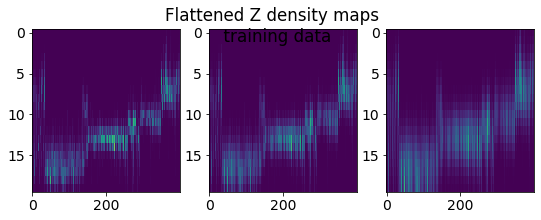

In [102]:
fig, axes = plt.subplots(1,3,figsize=(9,3))
for k,dm in enumerate([DM_c1, DM_c2, DM_c3]):
    
    axes[k].imshow(dm[train_index[np.argsort(labels_train)]].T)

    axes[k].set_aspect('auto')
plt.suptitle('Flattened Z density maps \n training data')

In [104]:
for k,dm in enumerate([DM_c1, DM_c2, DM_c3]):
    pca = PCA()
    pca_dm = pca.fit_transform(dm[train_index])
    
    no_components = np.where(np.cumsum(pca.explained_variance_ratio_) > .95)[0][0]
    print('Using %i principle components..'%no_components)
    
    with open('./data/Farrow_data/density_map/%s/z_dm_%ipcs_train_c%i.npy'%(part,
                                                                                no_components, (k+1)), 'wb') as f:
        np.save(f, pca_dm[:,:no_components])
        
    pca_dm_val = pca.transform(dm[val_index])
    with open('./data/Farrow_data/density_map/%s/z_dm_%ipcs_val_c%i.npy'%(part, 
                                                                              no_components, (k+1)), 'wb') as f:
        np.save(f, pca_dm_val[:,:no_components])
        
    pca_dm_test = pca.transform(dm[test_index])
    with open('./data/Farrow_data/density_map/%s/z_dm_%ipcs_test_c%i.npy'%(part, 
                                                                               no_components, (k+1)), 'wb') as f:
        np.save(f, pca_dm_test[:,:no_components])
        
for fn, data in [('train_labels', labels_train), ('val_labels', labels_val),('test_labels', labels_test)]:
    with open('./data/Farrow_data/density_map/%s/labels/%s.npy'%(part, fn), 'wb') as f:
        np.save(f, data)

Using 6 principle components..
Using 4 principle components..
Using 3 principle components..


CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 14.1 µs
CPU times: user 1.55 ms, sys: 872 µs, total: 2.42 ms
Wall time: 2.43 ms
CPU times: user 9.13 s, sys: 144 ms, total: 9.28 s
Wall time: 8.14 s


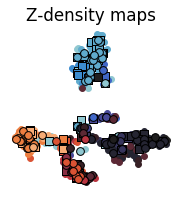

In [66]:
dm = DM_c2
DM_train = dm[train_index]
DM_val = dm[val_index]
DM_test = dm[test_index]

%time
affinities_train = PerplexityBasedNN(
    pca.fit_transform(DM_train),
    perplexity=30,
    metric="euclidean",
    n_jobs=2,
    random_state=17,
)

%time init_train = initialization.pca(pca.fit_transform(DM_train),random_state=17)

embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=2
)

%time embedding_train = embedding_train.optimize(n_iter=500, momentum=0.8)

embedding_val = embedding_train.prepare_partial(
    pca.transform(DM_val),
    initialization="median",
    k=5,
    perplexity=5,
)

embedding_test = embedding_train.prepare_partial(
    pca.transform(DM_test),
    initialization="median",
    k=5,
    perplexity=5,
)

plt.figure(figsize=(3,3))
colors = sns.color_palette('icefire', n_colors=15)
s=60
label_dict = {-100:'no label', 13: '8n/9n', 12: 'sONα', 11: 'F-midi ON', 
              10: 'tONα', 9:'6sn', 8:'F-mini ON', 7:'HD1/HD2', 
              6:'5to', 5:'tOFFα', 4: 'mini tOFFα', 3: 'ON-OFF DS',
             2: '27', 1:'F-mini-OFF', 0: 'sOFFα'}
for k,l in enumerate(np.unique(labels_train)):
    label_index_train = labels_train == l
    
    plt.scatter(embedding_train[label_index_train, 0], 
                embedding_train[label_index_train, 1], 
                alpha=1, c=[colors[k]],s=s-25, label=label_dict[l])

    label_index_val = labels_val == l
    plt.scatter(embedding_val[label_index_val, 0], 
                embedding_val[label_index_val, 1], 
                alpha=1, s=s, marker='s',edgecolors='k', c=[colors[k]], zorder=90)

    label_index_test = labels_test == l
    plt.scatter(embedding_test[label_index_test, 0], 
                embedding_test[label_index_test, 1], 
                alpha=1, edgecolors='k', s=s, c=[colors[k]], zorder=100)


sns.despine()
# plt.legend(frameon=False, bbox_to_anchor=(1.,.9), ncol=3)
plt.title('Z-density maps')
plt.axis('off')
plt.savefig("./pics/ICML/camera-ready/Suppl/tsne_RGC_dm.svg")

In [134]:
kfold = StratifiedKFold(n_splits=3, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

y = train_iterator.dataset.labels
y = np.array(y).astype(int)

for s,X in [(.5, DM_c1), (1., DM_c2), (2., DM_c3)]:
    
    r = 1
    for train_ix, test_ix in kfold.split(X,y):
        train_data = X[train_ix]
        train_labels = y[train_ix]

        test_data = X[test_ix]
        test_labels = y[test_ix]

        pca = PCA()
        pca_dm = pca.fit_transform(train_data)

        no_components = np.where(np.cumsum(pca.explained_variance_ratio_) > .95)[0][0]
        knn.fit(pca_dm[:,:no_components], train_labels)
        
        d_ = dict(run=r, n_pc=no_components, 
                  test_accuracy= knn.score(pca.transform(test_data)[:,:no_components], test_labels),
                 sigma=s, dataset='RGC')
        
        df = df.append(pd.DataFrame(d_, index=[0]))
        r += 1

## Overall performance of density maps

In [137]:
df.groupby(['dataset', 'sigma']).mean().round(2)*100

run     n_pc  test_accuracy
dataset sigma                               
M1 EXC  0.5    200.0   4067.0           62.0
        1.0    200.0   1433.0           65.0
        2.0    200.0    500.0           66.0
M1 INH  0.5    200.0   2267.0           59.0
        1.0    200.0    800.0           61.0
        2.0    200.0    400.0           58.0
RGC     0.5    200.0    600.0           56.0
        1.0    200.0    400.0           56.0
        2.0    200.0    300.0           55.0
Toy     0.5    200.0  10500.0           83.0
        1.0    200.0   2567.0           89.0
        2.0    200.0   1000.0           90.0